In [1]:
import vaex
import numpy as np
from matplotlib import pyplot as plt
from os.path import join, abspath
from os import pardir
from scipy import interpolate
from glob import glob
import sys

In [5]:
root_dir = abspath(join(pardir, pardir))
root_dir

'/home2/s20321005/Thesis-Project'

In [6]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/4_Vertical_Number/metal',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project/4_Vertical_Number',
 '/home2/s20321005/Thesis-Project']

In [7]:
from utils import safe_mkdir, style

style()

In [8]:
root_data_dir = abspath(join(root_dir, "Data"))
name = "metal"
comp_dir = join(root_data_dir, "Effective-Completeness", name)
spectral_dir = join(root_data_dir, "Cluster", name)

In [9]:
data_dir = join(root_data_dir, "Effective-Volume")
safe_mkdir(data_dir)
data_dir = join(root_data_dir, "Effective-Volume", name)
safe_mkdir(data_dir)

Directory /home2/s20321005/Thesis-Project/Data/Effective-Volume already exist. Good to go!
Directory /home2/s20321005/Thesis-Project/Data/Effective-Volume/metal already exist. Good to go!


In [10]:
files = glob(join(comp_dir, "*.hdf5"))
files.sort()
files

['/home2/s20321005/Thesis-Project/Data/Effective-Completeness/metal/gaia_(-0.00)_(0.14).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Completeness/metal/gaia_(0.14)_(0.33).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Completeness/metal/gaia_(0.33)_(0.37).hdf5']

In [11]:
name = files[2].split("/")[-1]
name

'gaia_(0.33)_(0.37).hdf5'

In [12]:
df_comp = vaex.open(join(comp_dir, name))
df_comp

#,DM,compDM
0,-2.0,9.874817861626135e-190
1,-1.8282828282828283,5.390788214224361e-77
2,-1.6565656565656566,1.1946366896832398e-36
3,-1.4848484848484849,1.6296771468010708e-22
4,-1.3131313131313131,1.7735803131654268e-16
...,...,...
95,14.313131313131311,0.0
96,14.484848484848484,0.0
97,14.656565656565657,0.0
98,14.828282828282827,0.0


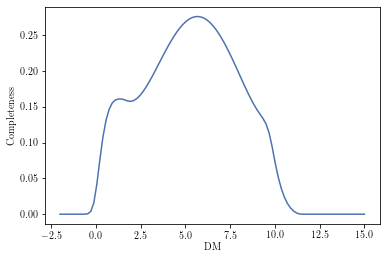

In [13]:
compDM = df_comp["compDM"].to_numpy()
DM = df_comp["DM"].to_numpy()

# plot
plt.plot(DM, compDM)
plt.xlabel("DM")
plt.ylabel("Completeness")
plt.show()


In [14]:
files

['/home2/s20321005/Thesis-Project/Data/Effective-Completeness/metal/gaia_(-0.00)_(0.14).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Completeness/metal/gaia_(0.14)_(0.33).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Completeness/metal/gaia_(0.33)_(0.37).hdf5']

# plot for all

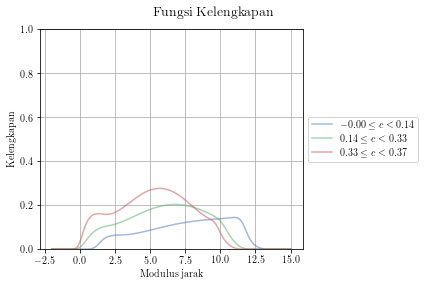

'gaia_(0.33)_(0.37).hdf5'

In [15]:
import re

# regex to extract number between ()
regex = re.compile(r"\((.*?)\)")

# plot
fig, ax = plt.subplots(figsize=(6, 4))
for file in files:
    name = file.split("/")[-1]
    c = regex.findall(name)
    df_comp = vaex.open(join(comp_dir, name))
    compDM = df_comp["compDM"].to_numpy()
    DM = df_comp["DM"].to_numpy()
    ax.plot(DM, compDM, label=r"${}\leq c < {}$".format(c[0], c[1]), alpha=0.5)
ax.set_xlabel("Modulus jarak")
ax.set_ylabel("Kelengkapan")
ax.set_ylim(0, 1)
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle("Fungsi Kelengkapan", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.90)
# fig.savefig(join('img', "fungsi-kelengkapan-no.pdf"), dpi=200)
plt.show()

name

interpolate compDM, set to 0 if beyond the range

In [16]:
compDM_interp = interpolate.interp1d(DM, compDM, fill_value=0, bounds_error=False)

compDM_interp(-20)

array(0.)

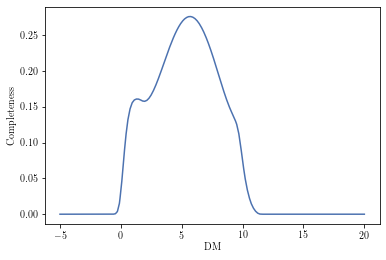

In [17]:
dms = np.linspace(-5, 20, 1000)
compDMs = compDM_interp(dms)

# plot
plt.plot(dms, compDMs)
plt.xlabel("DM")
plt.ylabel("Completeness")
plt.show()

In [18]:
R = 150
Z = 400

In [19]:
# divide space into small tube with rings
ez = np.linspace(-Z, Z, 100) #edges
er = np.linspace(0, R, 100)
z = (ez[:-1]+ez[1:])/2
r = (er[:-1]+er[1:])/2

dz = ez[1]-ez[0]

In [20]:
from tqdm import tqdm

frac = []
for zz in tqdm(z):
    real_vol = 0
    eff_vol = 0
    for j, (rr, r_in, r_out) in enumerate(zip(r, er[:-1], er[1:])):
        glat = np.arctan(zz/rr)
        dv = np.pi*(r_out**2-r_in**2)*dz
        real_vol += dv
        distance =np.sqrt(rr**2+zz**2)
        dm = 5*np.log10(distance)-5
        # b = np.arctan(zz/rr)
        # if np.abs(zz) < 50:
        eff_vol += dv*compDM_interp(dm)
    frac.append(eff_vol/real_vol)


100%|██████████| 99/99 [00:00<00:00, 396.26it/s]


(0.0, 1.0)

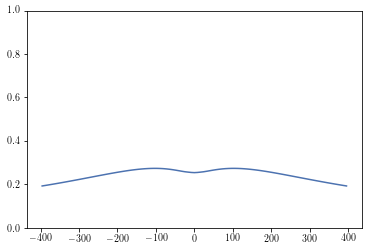

In [21]:
plt.plot(z, frac)
plt.ylim(0,1)

# all out

only for index 0 and 2, cut the midplane

100%|██████████| 499/499 [00:01<00:00, 397.67it/s]


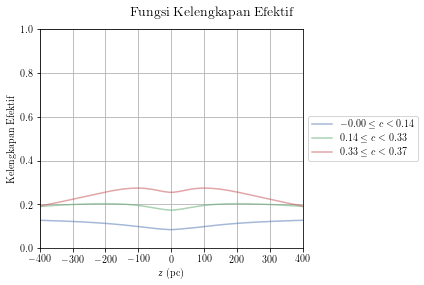

In [23]:
from tqdm import tqdm
import re
import matplotlib.pylab as pl

# regex to extract number between ()
regex = re.compile(r"\((.*?)\)")
Z = 400
R = 150
ez = np.linspace(-Z, Z, 500) #edges
er = np.linspace(0, R, 100)
z = (ez[:-1]+ez[1:])/2
r = (er[:-1]+er[1:])/2
dms = np.linspace(-20, 20, 1000)
dz = ez[1]-ez[0]
colors = pl.cm.jet(np.linspace(0,1,len(files)))
fig, ax = plt.subplots(figsize=(6, 4))
fracs = np.empty((len(files), len(z)))
for i, file in enumerate(files):
    name = file.split("/")[-1]
    c = regex.findall(name)
    df_comp = vaex.open(join(comp_dir, name))
    compDM = df_comp["compDM"].to_numpy()
    DM = df_comp["DM"].to_numpy()
    compDM_interp = interpolate.interp1d(DM, compDM, fill_value=0, bounds_error=False)
    compDMs = compDM_interp(dms)

    frac = []
    for zz in tqdm(z):
        real_vol = 0
        eff_vol = 0
        for j, (rr, r_in, r_out) in enumerate(zip(r, er[:-1], er[1:])):
            glat = np.arctan(zz/rr)
            dv = np.pi*(r_out**2-r_in**2)*dz
            real_vol += dv
            distance =np.sqrt(rr**2+zz**2)
            dm = 5*np.log10(distance)-5
            b = np.arctan(zz/rr)
            # if np.abs(zz) < 13.79310345 and i < 1:
            #     continue
            eff_vol += dv*compDM_interp(dm)
        frac.append(eff_vol/real_vol)
    ax.plot(z, frac, label=r"${}\leq c < {}$".format(c[0], c[1]), alpha=0.5)
    fracs[i] = frac
ax.set_xlabel(r"$z$ (pc)")
ax.set_ylabel("Kelengkapan Efektif")
ax.grid()
ax.set_ylim(0,1)
ax.set_xlim(-Z, Z)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle("Fungsi Kelengkapan Efektif", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.90)
fig.savefig(join('..', 'img', "fungsi-kelengkapan-efektif-metal.pdf"), dpi=200)

In [24]:
df = vaex.from_arrays(z=z)
for i in range(len(files)):
    df[str(i)] = fracs[i]
df

#,z,0,1,2
0,-399.19839679358716,0.12664700602365184,0.19030401127342206,0.19215908054320238
1,-397.59519038076155,0.12657866270498866,0.19045824500709957,0.19261217184355234
2,-395.9919839679359,0.1265098183900226,0.19061205703263853,0.1930671273686763
3,-394.3887775551102,0.12644052743623704,0.1907656584899403,0.19352390010210854
4,-392.78557114228454,0.12637097499919592,0.19091974608207646,0.1939823087784687
...,...,...,...,...
494,392.7855711422846,0.12637097499919592,0.19091974608207646,0.1939823087784687
495,394.38877755511027,0.12644052743623704,0.1907656584899403,0.19352390010210851
496,395.99198396793594,0.1265098183900226,0.19061205703263853,0.19306712736867626
497,397.59519038076155,0.12657866270498866,0.19045824500709957,0.19261217184355234


In [25]:
df.export(join(data_dir, "effective-volume-completeness.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :     0.04s =  0.0m =  0.0h
 

see example

In [47]:
index = 0
name = files[index].split("/")[-1] 
gaia = vaex.open(join(spectral_dir, name))
compz = interpolate.interp1d(z, fracs[index], fill_value='interpolate', bounds_error=False)
if index < 1:
    gaia = gaia.filter(f"abs(z) > 13.79310345")
    gaia = gaia.extract()
gaia

#,ra,dec,Jmag,Kmag,ph_qual,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,GLON,GLAT,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,subclass_lamost,rv,rv_cat,rv_el,rv_eu,rv_sym,teff,teff_cat,teff_el,teff_eu,teff_sym,logg,logg_cat,logg_el,logg_eu,logg_sym,feh,feh_cat,feh_el,feh_eu,feh_sym,mh,mh_cat,mh_el,mh_eu,mh_sym,alphafe,alphafe_cat,alphafe_el,alphafe_eu,alphafe_sym,alpham,alpham_cat,alpham_el,alpham_eu,alpham_sym,JK,M_J,Dist,z,r,pmlon,pmlat,e_pmlon,e_pmlat,vb,vphi,e_vb,e_vphi,w,e_rv,e_w,v_xy,e_v_xy,v,e_v,u,e_u,M_J_lower,M_J_upper
0,0.014884639099905679,-0.6277107372592441,8.755000114440918,8.656999588012695,AAA,2309518882743792512,23.22193717956543,22.29106181287425,0.015476686879992485,6.508986172951364,0.016319049522280693,4.789413549620276,0.020170677453279495,9.131726264953613,9.230249404907227,8.934432983398438,1889.544189453125,2443.355224609375,1.1517304182052612,1.167120337486267,2.951179464847555,-1.3351842543237686,208.5220947265625,204.33360290527344,210.59359741210938,0.003100000089034438,0.0010000000474974513,0.00570000009611249,nan,nan,nan,A,--,13.979635238647461,gaia,0.8730981349945068,0.8730981349945068,1.0,7851.72216796875,gspphot,7.68994140625,6.4814453125,0.0,4.14709997177124,gspphot,0.008999824523925781,0.014599800109863281,0.0,nan,--,nan,nan,nan,-1.2071000337600708,gspphot,0.004799962043762207,0.006800055503845215,0.0,0.12999999523162842,rave,nan,nan,-1.0,nan,--,nan,nan,nan,0.09800052642822266,2.1564118070290146,208.79383031755194,-203.02519970723176,48.7404540655227,-8.415224816113692,-21.64352857182297,0.016011703235616633,0.015794447555597668,-21.420227000145907,-8.328402885890153,-0.09155582963669412,-0.038488697266941825,-18.593699921256633,0.8730981349945068,0.8492448485468144,-17.56504054597298,0.22240955574805651,15.671299950086627,0.21851120838760413,11.50231723983446,0.056570682463120345,0.656183260425856,2.2724350893667364
1,0.008917061681364228,-0.048279332675252175,6.333000183105469,6.209000110626221,AAA,2448569690198755840,38.3818473815918,38.23798058974192,0.03215809911489487,-3.320105645310672,0.02077770233154297,15.648562219917743,0.03183779865503311,6.871397018432617,7.007111549377441,6.608101844787598,716.1038818359375,1091.4459228515625,1.0634098052978516,1.1764565706253052,-1.4844818198754623,-1.0982041189149518,63.59870147705078,62.819698333740234,63.837398529052734,0.00039999998989515007,0.0,0.001500000013038516,nan,nan,nan,A,--,9.158726692199707,gaia,0.3001042306423187,0.3001042306423187,1.0,7234.37060546875,gspphot,3.57373046875,3.30517578125,0.0,4.155799865722656,gspphot,0.003200054168701172,0.00820016860961914,0.0,nan,--,nan,nan,nan,-1.3895000219345093,gspphot,0.062399983406066895,0.07220005989074707,0.0,nan,--,nan,nan,nan,nan,--,nan,nan,nan,0.12400007247924805,2.305372388159757,63.90363446471675,-56.8992413574995,29.08867186279142,33.346648213326496,-19.00440249032187,0.030476525523901784,0.023174072685925768,-5.756494848419319,10.100807365547125,-0.013654361742468372,0.02252880254356858,-10.775183541282718,0.3001042306423187,0.2672824782536821,-0.9565182768560057,0.13714615438495595,-10.145663157583355,0.025368455825438258,-0.08219332519347466,0.13664939098167272,0.7641710959654313,2.3284855063378016
2,0.017169798689541858,0.2509584496833118,6.4629998207092285,6.3420000076293945,AAA,2768911028561373184,82.73104095458984,79.9700922599516,0.03658584877848625,-21.1945508376773,0.032072752714157104,12.846665601946027,0.030333148315548897,7.028295993804932,7.170999526977539,6.754446983337402,1664.38427734375,2524.64306640625,1.1126266717910767,1.177590012550354,-1.2921946921475476,-0.8189414254694577,77.58290100097656,77.27890014648438,77.88099670410156,0.005400000140070915,0.001500000013038516,0.016599999740719795,nan,nan,nan,F,--,-5.97739839553833,gaia,0.1642320305109024,0.16423203

27.586206896551744

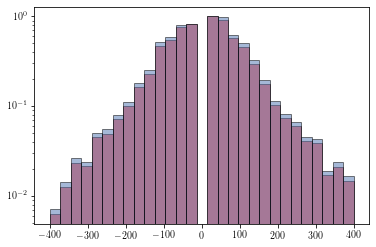

In [48]:
zedge = np.linspace(-400, 400, 30) #edges
zmid = (zedge[:-1]+zedge[1:])/2
zs = gaia["z"].to_numpy()
dz = zedge[1]-zedge[0]
znum, _ = np.histogram(zs, bins=zedge)
zcor = znum/compz(zmid)
mask = znum > 0
zcor = zcor[mask]
zmid = zmid[mask]

znum_raw, _ = np.histogram(zs, bins=zedge)
znum_raw = znum_raw[mask]

dz = zedge[1]-zedge[0]
plt.bar(zmid, zcor/zcor.max(), width=dz, edgecolor="k", alpha=0.5, color="r")
plt.bar(zmid, znum_raw/znum_raw.max(), width=dz, edgecolor="k", alpha=0.5)
plt.yscale("log")
dz

# All out

<ipython-input-91-af024fe05d17>:60: RuntimeWarning: invalid value encountered in divide
  zcor = np.select([compz(zmid) > 0], [znum/compz(zmid)], default=0)


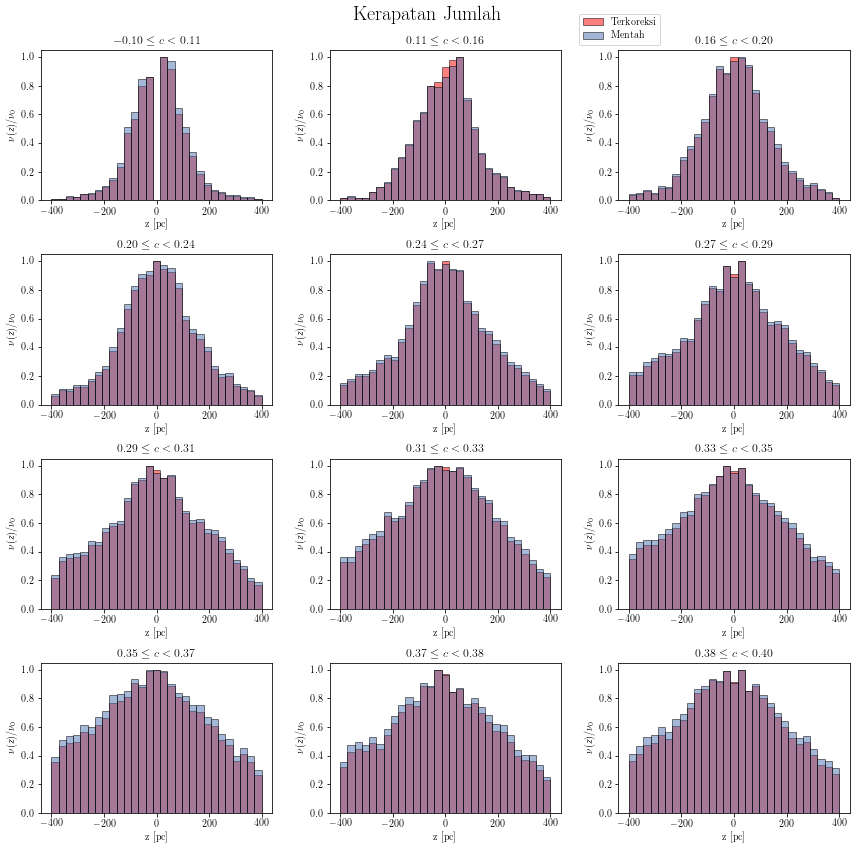

In [91]:
import re

# regex to extract the number from the file name inside ()
regex = re.compile(r"\((.*?)\)")

Z = 396.44960851
R = 150
er = np.linspace(0, R, 100)
r = (er[:-1]+er[1:])/2

fig, axes = plt.subplots(4, 3, figsize=(12, 12))
for i, (file, ax) in enumerate(zip(files, axes.flatten())):
    ez = np.linspace(-Z, Z, 500)  # edges
    z = (ez[:-1]+ez[1:])/2
    dz = ez[1]-ez[0]

    name = file.split("/")[-1]
    c = regex.findall(name)
    df_comp = vaex.open(join(comp_dir, name))

    compDM = df_comp["compDM"].to_numpy()
    DM = df_comp["DM"].to_numpy()
    # plt.plot(DM, compDM)
    # plt.show()

    # interpolate compDM, set to 0 if beyong the range
    compDM_interp = interpolate.interp1d(
        DM, compDM, fill_value=0, bounds_error=False)

    frac = []
    for zz in z:
        real_vol = 0
        eff_vol = 0
        for j, (rr, r_in, r_out) in enumerate(zip(r, er[:-1], er[1:])):
            glat = np.arctan(zz/rr)
            dv = np.pi*(r_out**2-r_in**2)*dz
            real_vol += dv
            distance = np.sqrt(rr**2+zz**2)
            dm = 5*np.log10(distance)-5
            if np.abs(zz) < 13.79310345 and i < 1:
                continue
            eff_vol += dv*compDM_interp(dm)
        frac.append(eff_vol/real_vol)

    compz = interpolate.interp1d(
        z, frac, fill_value='interpolate', bounds_error=False)
    # plt.plot(z, frac)
    # plt.show()
    gaia = vaex.open(join(spectral_dir, name))
    if i < 1:
        gaia = gaia.filter(f"abs(z) > 13.79310345")
        gaia = gaia.extract()

    zedge = np.linspace(-400, 400, 30)  # edges
    zmid = (zedge[:-1]+zedge[1:])/2
    zs = gaia["z"].to_numpy()
    dz = zedge[1]-zedge[0]
    znum, _ = np.histogram(zs, bins=zedge)
    # print(compz(zmid))
    zcor = np.select([compz(zmid) > 0], [znum/compz(zmid)], default=0) 
    # print(zcor)
    mask = zcor > 0
    zcor = zcor[mask]
    zmid = zmid[mask]

    znum_raw, _ = np.histogram(zs, bins=zedge)
    znum_raw = znum_raw[mask]
    # break
    dz = zedge[1]-zedge[0]
    ax.bar(zmid, zcor/zcor.max(), width=dz,
            edgecolor="k", alpha=0.5, color="r")
    ax.bar(zmid, znum_raw/znum_raw.max(), width=dz, edgecolor="k", alpha=0.5)
    # ax.set_yscale("log")
    ax.set_title(r"${}\leq c < {}$".format(c[0], c[1]))
    ax.set_xlabel("z [pc]")
    ax.set_ylabel(r"$\nu(z)/\nu_0$")
    # df.export(join(data_dir, name), progress=True)
    if i == 2:
        ax.legend(["Terkoreksi", "Mentah"], loc="lower right",
                  bbox_to_anchor=(0.2, 1.0))
        # break
fig.tight_layout()
fig.suptitle("Kerapatan Jumlah", fontsize=20)
fig.subplots_adjust(top=0.93)
fig.savefig(join("img", "kerapatan-jumlah-no.pdf"), bbox_inches="tight")